# OCB Workshop 2021 - Age tracers in select CMIP6 models

In [1]:
import cartopy.crs as ccrs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina'
xr.set_options(cmap_sequential='cividis', display_style='html', keep_attrs=True)
import cmocean.cm as cmo
from dask.diagnostics import ProgressBar

from cmip6_preprocessing.utils import google_cmip_col
from cmip6_preprocessing.preprocessing import combined_preprocessing

In [2]:
col = google_cmip_col()
cat = col.search(
    experiment_id='historical',
    variable_id='agessc',
    grid_label='gn',
    table_id='Omon',
    source_id = ['CanESM5', 'CESM2', 'IPSL-CM6A-LR', 'MIROC-ES2L'],
)
ddict = cat.to_dataset_dict(
    zarr_kwargs={'consolidated':True, 'use_cftime':True},
    preprocess=combined_preprocessing,
    aggregate=False,
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


/srv/conda/envs/ocb_workshop_2021_cmip6_age/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:211: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')
/srv/conda/envs/ocb_workshop_2021_cmip6_age/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:211: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')
/srv/conda/envs/ocb_workshop_2021_cmip6_age/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:211: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')


In [3]:
from cmip6_preprocessing.postprocessing import combine_datasets 

def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

ddict_new = combine_datasets(ddict, pick_first_member, match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id'])

CanESM5.gn.historical.Omon
[########################################] | 100% Completed |  2.8s


/srv/conda/envs/ocb_workshop_2021_cmip6_age/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/ocb_workshop_2021_cmip6_age/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


CESM2.gn.historical.Omon
[########################################] | 100% Completed |  5.0s


/srv/conda/envs/ocb_workshop_2021_cmip6_age/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/ocb_workshop_2021_cmip6_age/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


IPSL-CM6A-LR.gn.historical.Omon
[########################################] | 100% Completed |  5.1s


/srv/conda/envs/ocb_workshop_2021_cmip6_age/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/ocb_workshop_2021_cmip6_age/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


MIROC-ES2L.gn.historical.Omon
[########################################] | 100% Completed |  3.6s


/srv/conda/envs/ocb_workshop_2021_cmip6_age/lib/python3.9/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/ocb_workshop_2021_cmip6_age/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1702: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,


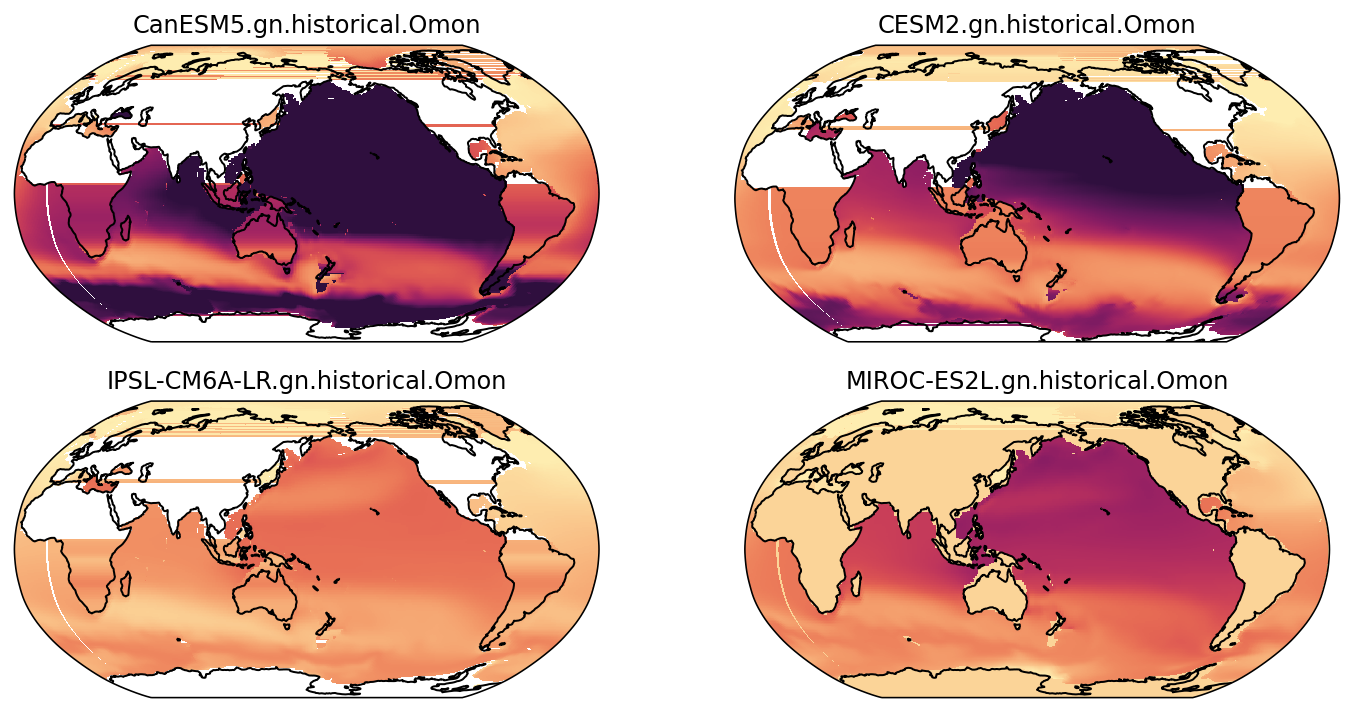

In [5]:
fig, axarr = plt.subplots(nrows=2, ncols=2, subplot_kw={'projection':ccrs.Robinson(160)})
count = 0

target_depth = 1000 # set the depth you are interested in [in m]
years = 2 # number of years at the end of the control run to average


for (name, ds), ax in zip(ddict_new.items(), axarr.flat):
    print(name)
    ds = ds.isel(time=slice(-years * 12, None)).mean(['time']).interp(lev=target_depth)
    
    with ProgressBar():
        ds = ds.load()
    try:
        ds.agessc.plot(ax=ax,x='lon', y='lat', transform=ccrs.PlateCarree(), cmap=cmo.matter, vmin=50, vmax=1500, add_colorbar=False)
        ax.coastlines()
    except Exception as e:
        print(f"{name} failed with: {e}")
    ax.set_title(name)